# HDA - Project 3: TASK A
## Rows labelled with category 0 has been dropped
### In this context, first we dropped the rows and then missing values are interpolated using splines
Importing all modules that we need for our elaboration

In [46]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import itertools

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    
    from keras import regularizers
    from keras.layers import Conv1D, Conv2D, BatchNormalization, Dropout, LeakyReLU, Flatten, Activation, Dense, MaxPooling1D
    from keras.models import Model, Sequential
    from keras.optimizers import Adam
    import keras.backend as K
    
K.set_image_data_format('channels_last')

%matplotlib inline

# Preprocessing Section
Importing data sessions for subject 1

In [47]:
x1 = scipy.io.loadmat("prep/A_nonzero/S1-ADL1", mdict={'filled_features':'features', 'labels':'labels'})
x2 = scipy.io.loadmat("prep/A_nonzero/S1-ADL2", mdict={'filled_features':'features', 'labels':'labels'})
x3 = scipy.io.loadmat("prep/A_nonzero/S1-ADL3", mdict={'filled_features':'features', 'labels':'labels'})
x4 = scipy.io.loadmat("prep/A_nonzero/S1-ADL4", mdict={'filled_features':'features', 'labels':'labels'})
x5 = scipy.io.loadmat("prep/A_nonzero/S1-ADL5", mdict={'filled_features':'features', 'labels':'labels'})
x6 = scipy.io.loadmat("prep/A_nonzero/S1-Drill", mdict={'filled_features':'features', 'labels':'labels'})

Check the number of recorded samples for each session

In [48]:
print("Session shapes:\n")
print("ADL1:  ", x1['filled_features'].shape)
print("ADL2:  ", x2['filled_features'].shape)
print("ADL3:  ", x3['filled_features'].shape)
print("ADL4:  ", x4['filled_features'].shape)
print("ADL5:  ", x5['filled_features'].shape)
print("Drill: ", x6['filled_features'].shape)
print("\nTraining set: ADL1 + ADL2 + ADL3 + Drill = ", x1['filled_features'].shape[0] + x2['filled_features'].shape[0] + x3['filled_features'].shape[0] + x6['filled_features'].shape[0])
print("Test set: ADL4 + ADL5 = ", x4['filled_features'].shape[0] + x5['filled_features'].shape[0])

Session shapes:

ADL1:   (37507, 113)
ADL2:   (24510, 113)
ADL3:   (25305, 113)
ADL4:   (24851, 113)
ADL5:   (22440, 113)
Drill:  (52105, 113)

Training set: ADL1 + ADL2 + ADL3 + Drill =  139427
Test set: ADL4 + ADL5 =  47291


We split the data into train and test set.

In [50]:
# features
X_train = np.concatenate((x1['filled_features'],x2['filled_features'],x3['filled_features'],x6['filled_features']),axis=0)
X_test = np.concatenate((x4['filled_features'],x5['filled_features']),axis=0)

# labels (locomotion activity)
Y_train = np.concatenate((x1['labels'][:,0],x2['labels'][:,0],x3['labels'][:,0],x6['labels'][:,0]),axis=0) # here we take just the first column because we want to fulfill the first task
Y_test = np.concatenate((x4['labels'][:,0],x5['labels'][:,0]))
#Y_test = np.concatenate((x4['labels'][:,0],x5['labels'][:,0]),axis=0)

# Initial decision to overcome the problem of entire missing columns
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)


X_train shape:  (139427, 113)
X_test shape:  (47291, 113)


The dataset needs to be normalized in order to improve performances.

In [51]:
# fatures normalization
scaler = StandardScaler().fit(X_train)
X_train =scaler.transform(X_train)
X_test = scaler.transform(X_test)

We decided to use a onehot encoder for the labels

In [54]:
label_max = np.max(Y_train)
print("The highest label value is: ", label_max)
onehot_encoder = OneHotEncoder(sparse=False)
YOH_train = onehot_encoder.fit_transform(Y_train.reshape(-1, 1))
YOH_test = onehot_encoder.fit_transform(Y_test.reshape(-1, 1))

print("YOH_train shape: ", YOH_train.shape)
print("YOH_test shape: ", YOH_test.shape)

The highest label value is:  5
YOH_train shape:  (139427, 4)
YOH_test shape:  (47291, 4)


In [55]:
Y_train

array([1, 1, 1, ..., 2, 2, 2])

In [56]:
window_size = 10
stride = int(window_size / 2)
num_features = X_train.shape[1]
samples, classes = YOH_train.shape
print("Number of samples: ", samples, "\nNumber of classes: ", classes)

windows = int(samples // stride) - 1
print("Number of windows: ", windows)

Number of samples:  139427 
Number of classes:  4
Number of windows:  27884


In [57]:
num_features_test = X_test.shape[1]
samples_test, classes_test = YOH_test.shape
print("Number of samples: ", samples_test, "\nNumber of classes: ", classes_test)

windows_test = int(samples_test // stride) - 1
print("Number of windows: ", windows_test)

Number of samples:  47291 
Number of classes:  4
Number of windows:  9457


In [58]:
cube = np.zeros([windows, window_size, num_features])
cube.shape

(27884, 10, 113)

In [59]:
cube_test = np.zeros([windows_test, window_size, num_features])
cube_test.shape

(9457, 10, 113)

In [60]:
lab_cum = np.zeros([windows])
lab_cum.shape

(27884,)

In [61]:
lab_cum_test = np.zeros([windows_test])
lab_cum_test.shape

(9457,)

In [62]:
for w in range(windows):
    index = int(w * stride)
    cube[w,:,:] = X_train[index:index+window_size, :].reshape((window_size,num_features))
    l = YOH_train[index:index+window_size,:] # shape 50 x 5
    #print(np.sum(l, axis=0),np.argmax(np.sum(l, axis=0)))
    lab_cum[w] = np.argmax(np.sum(l, axis=0))

In [63]:
for w in range(windows_test):
    index = int(w * stride)
    cube_test[w,:,:] = X_test[index:index+window_size, :].reshape((window_size,num_features))
    l = YOH_test[index:index+window_size,:] # shape 50 x 5
    #print(np.sum(l, axis=0),np.argmax(np.sum(l, axis=0)))
    lab_cum_test[w] = np.argmax(np.sum(l, axis=0))

In [64]:
#print('cumulative labels: ', lab_cum.shape, type(lab_cum), "\n", lab_cum)
YOH_train_final = onehot_encoder.fit_transform(lab_cum.reshape(-1, 1))
print(YOH_train_final)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [65]:
YOH_test_final = onehot_encoder.fit_transform(lab_cum_test.reshape(-1, 1))
print(YOH_test_final)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


# 1D Convolutional Neural Network

In [66]:
def TestModel(input_shape):
    """ 
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns: 
    model -- a Model() instance in Keras
    """
    
    model = Sequential()
    model.add(Conv1D(filters = 18,
                    kernel_size=5,
                    strides=1,
                    padding='same',
                    input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2,
                          strides=2,
                          padding='same'))
    
    model.add(Conv1D(filters = 36,
                    kernel_size=7,
                    strides=1,
                    padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2,
                          strides=2,
                          padding='same'))
    
    model.add(Dropout(0.2))
    
    model.add(Conv1D(filters = 72,
                    kernel_size=7,
                    strides=1,
                    padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2,
                          strides=2,
                          padding='same'))
    
    #model.add(Conv1D(filters = 144,
    #                kernel_size=7,
    #                strides=1,
    #                padding='same'))
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))
    #model.add(MaxPooling1D(pool_size=2,
    #                      strides=2,
    #                      padding='same'))
    
    model.add(Flatten())
    
    model.add(Dense(64, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('relu'))
    
    model.add(Dropout(0.4))

    model.add(Dense(classes))
    model.add(Activation('softmax'))
    
    #model.summary()
    
    return model

In [67]:
model_test = TestModel((10,113))

In [68]:
opt = Adam(lr=0.01)
model_test.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [69]:
model_test.fit(x = cube, y = YOH_train_final, epochs = 5, batch_size = 128, validation_data=(cube_test,YOH_test_final))

Train on 27884 samples, validate on 9457 samples
Epoch 1/5
27884/27884 [==============================] - 6s 233us/step - loss: 0.4684 - acc: 0.8607 - val_loss: 0.3179 - val_acc: 0.9296
Epoch 2/5
27884/27884 [==============================] - 6s 198us/step - loss: 0.2876 - acc: 0.8957 - val_loss: 0.3553 - val_acc: 0.9181
Epoch 3/5
27884/27884 [==============================] - 5s 194us/step - loss: 0.2552 - acc: 0.9086 - val_loss: 0.2825 - val_acc: 0.9248
Epoch 4/5
27884/27884 [==============================] - 5s 195us/step - loss: 0.2412 - acc: 0.9165 - val_loss: 0.3378 - val_acc: 0.9116
Epoch 5/5
27884/27884 [==============================] - 6s 197us/step - loss: 0.2221 - acc: 0.9217 - val_loss: 0.3326 - val_acc: 0.9142


In [70]:
y_pred = model_test.predict(cube_test)
print("y_pred:\n", y_pred)

y_pred_hard = np.argmax(y_pred, axis=1)
print("\ny_pred_hard:\n", y_pred_hard)

YOH_pred = onehot_encoder.fit_transform(y_pred_hard.reshape(-1, 1))
print("\nYOH_pred:\n", YOH_pred)

y_pred:
 [[9.29e-01 7.09e-02 1.36e-04 8.24e-06]
 [8.27e-01 1.72e-01 5.57e-04 6.00e-05]
 [7.31e-01 2.68e-01 9.57e-04 1.49e-04]
 ...
 [0.00e+00 1.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 1.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 1.00e+00 0.00e+00 0.00e+00]]

y_pred_hard:
 [0 0 0 ... 1 1 1]

YOH_pred:
 [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [72]:
print("F1-measure: ", f1_score(YOH_test_final, YOH_pred, average='weighted'))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(classes):
    fpr[i], tpr[i], _ = roc_curve(YOH_test_final[:, i], YOH_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

print(roc_auc)

F1-measure:  0.914866383161378
{0: 0.9171986916459706, 1: 0.9142615996831773, 2: 0.9950638830971319, 3: 0.9026040058926426}


Confusion matrix, without normalization
[[3473  462   33    1]
 [ 223 2087    2    1]
 [   0    3 2730    0]
 [   0   62   24  356]]


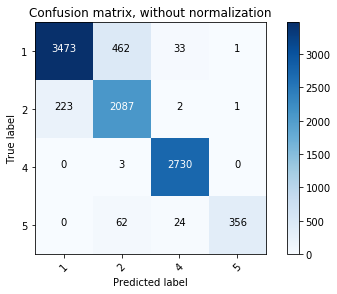

In [74]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix

y_test_hard = np.argmax(YOH_test_final, axis=1)
cnf_matrix = confusion_matrix(y_test_hard, y_pred_hard)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,4,5],
                      title='Confusion matrix, without normalization')